In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from params import subject_keys, eeg_chans, run_keys
from compute_power_at_resp import power_at_resp_job
from bibliotheque import get_pos, init_nan_da, df_baseline, get_df_mask_chan_signif
import mne
import os
from configuration import base_folder

In [12]:
mask_params = dict(markersize=15, markerfacecolor='y')

In [13]:
concat = []
for run_key in run_keys:
    participant, session = run_key.split('_')
    power_at_resp_participant = power_at_resp_job.get(run_key).to_dataframe()
    concat.append(power_at_resp_participant)
power_at_resp = pd.concat(concat).reset_index(drop = True)

<AxesSubplot: >

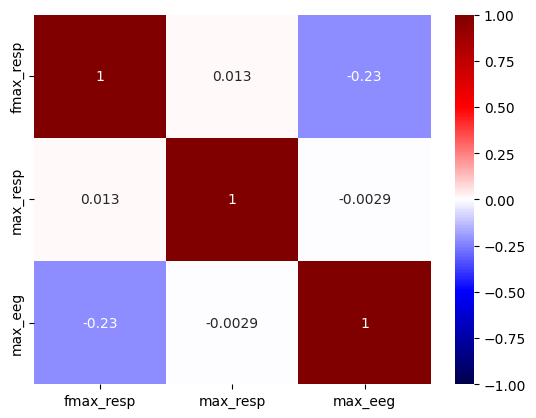

In [14]:
sns.heatmap(power_at_resp.corr(numeric_only = True), cmap = 'seismic', vmin = -1 , vmax = 1 , annot = True)

In [15]:
power_at_resp

session chan participant  fmax_resp     max_resp       max_eeg
0     baseline  Fp1         P01       0.36   620.517872  1.169588e-12
1     baseline   Fz         P01       0.36   620.517872  2.607854e-13
2     baseline   F3         P01       0.36   620.517872  1.148734e-12
3     baseline   F7         P01       0.36   620.517872  4.263217e-12
4     baseline  FT9         P01       0.36   620.517872  5.405662e-12
...        ...  ...         ...        ...          ...           ...
2785      odor  FC6         P31       0.18  1976.172697  1.489645e-12
2786      odor  FC2         P31       0.18  1976.172697  1.040321e-12
2787      odor   F4         P31       0.18  1976.172697  3.955177e-12
2788      odor   F8         P31       0.18  1976.172697  4.862520e-12
2789      odor  Fp2         P31       0.18  1976.172697  1.488216e-12

[2790 rows x 6 columns]

In [16]:
power_at_resp['log_max_eeg'] = np.log(power_at_resp['max_eeg'].values)

In [17]:
indexes = ['participant','session','chan']
metrics = ['fmax_resp','max_resp','max_eeg','log_max_eeg']

In [18]:
power_at_resp_baselined = df_baseline(df = power_at_resp, indexes = indexes, metrics= metrics, mode = 'substract')

In [19]:
power_at_resp_baselined

participant session chan  fmax_resp     max_resp       max_eeg   
0            P01    odor  Fp1       0.00  -374.957554 -1.296162e-13  \
1            P01    odor   Fz       0.00  -374.957554  1.509711e-13   
2            P01    odor   F3       0.00  -374.957554 -5.721781e-13   
3            P01    odor   F7       0.00  -374.957554 -2.490259e-12   
4            P01    odor  FT9       0.00  -374.957554 -8.162423e-13   
...          ...     ...  ...        ...          ...           ...   
1855         P31   music  FC6      -0.06  2466.900185  8.110159e-13   
1856         P31   music  FC2      -0.06  2466.900185  2.673707e-13   
1857         P31   music   F4      -0.06  2466.900185 -1.221806e-13   
1858         P31   music   F8      -0.06  2466.900185 -6.934970e-13   
1859         P31   music  Fp2      -0.06  2466.900185 -5.490575e-13   

      log_max_eeg  
0       -0.117458  
1        0.456734  
2       -0.689344  
3       -0.877375  
4       -0.163693  
...           ...  
1855     0.419872  
1856     0.555822  
1857    -0.047925  
1858    -0.142558  
1859    -0.265160  

[1860 rows x 7 columns]

<AxesSubplot: xlabel='chan', ylabel='log_max_eeg'>

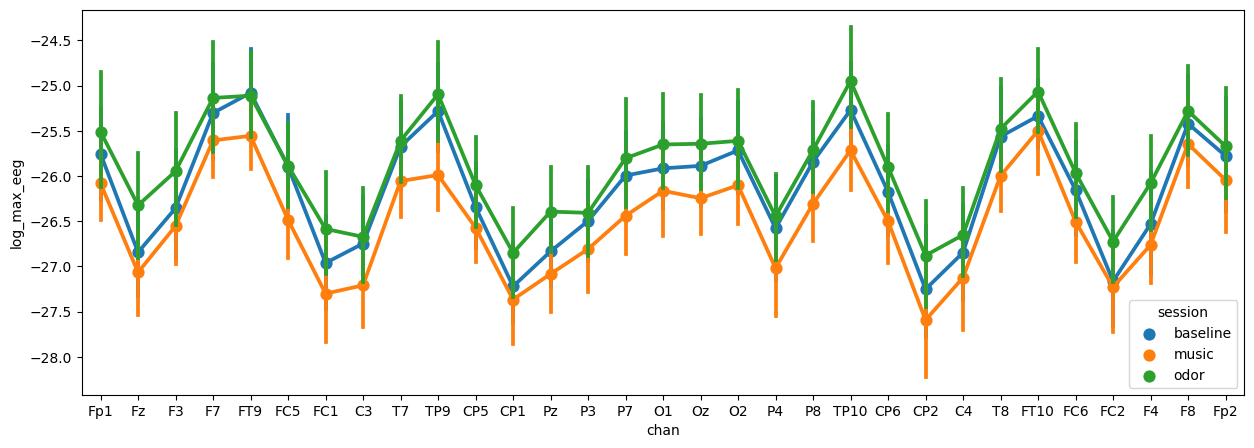

In [20]:
fig, ax = plt.subplots(figsize = (15,5))
sns.pointplot(data = power_at_resp, x = 'chan', y = 'log_max_eeg', hue = 'session',ax=ax)

<AxesSubplot: xlabel='chan', ylabel='log_max_eeg'>

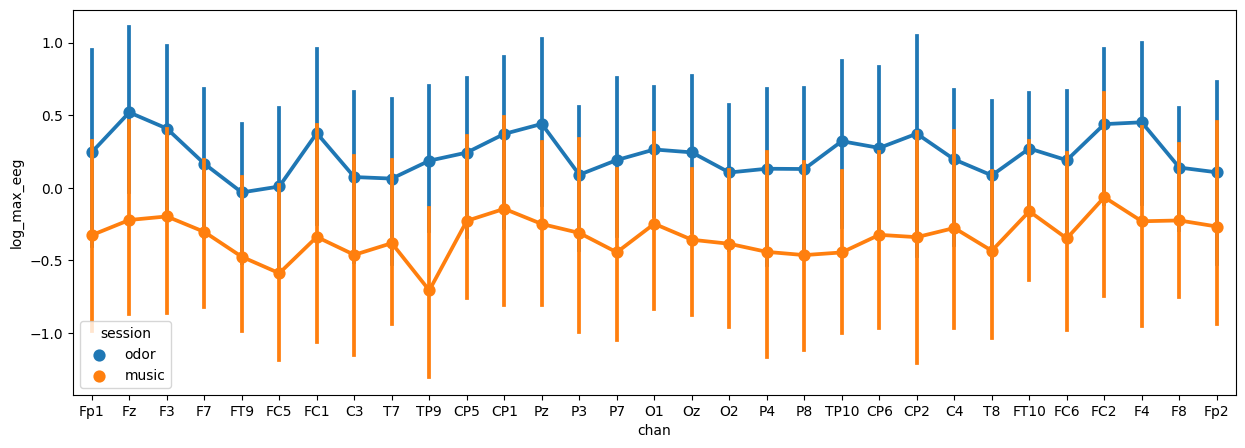

In [21]:
fig, ax = plt.subplots(figsize = (15,5))
sns.pointplot(data = power_at_resp_baselined, x = 'chan', y = 'log_max_eeg', hue = 'session',ax=ax)

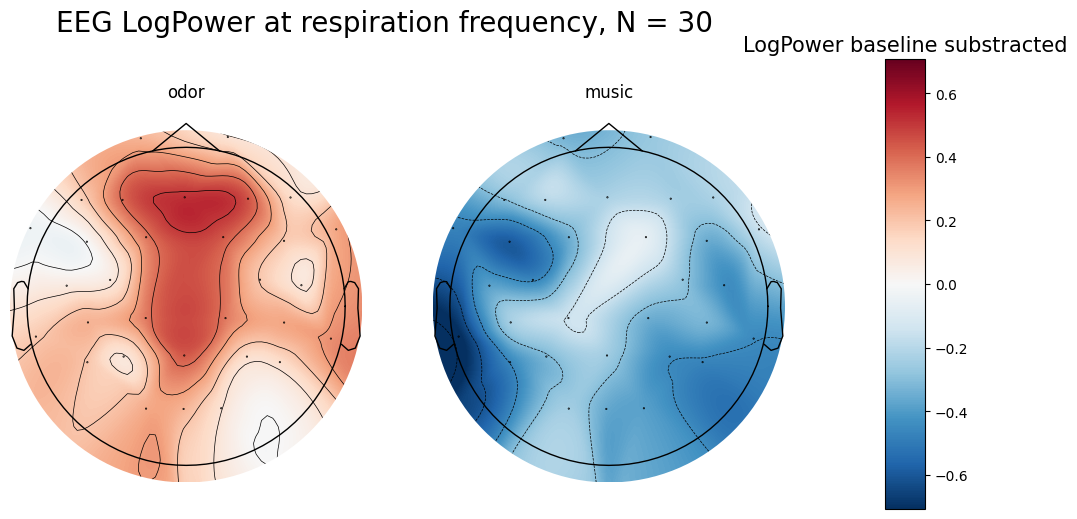

In [25]:
delta_quantile = 0.

colname = 'log_max_eeg'

df = power_at_resp_baselined

df_mask = get_df_mask_chan_signif(df = df, chans = eeg_chans, predictor = 'session', outcome = 'log_max_eeg', subject = 'participant')

N = power_at_resp_baselined['participant'].unique().size

vmin = np.quantile(df.groupby(['session','chan']).mean(numeric_only = True)[colname].values, delta_quantile)
vmax = np.quantile(df.groupby(['session','chan']).mean(numeric_only = True)[colname].values, 1 - delta_quantile)

vmin = vmin if abs(vmin) > abs(vmax) else -vmax
vmax = vmax if abs(vmin) < abs(vmax) else abs(vmin)
    
pos = get_pos()

fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
fig.suptitle(f'EEG LogPower at respiration frequency, N = {N}', fontsize = 20, y = 1.1)

for c, session in enumerate(df['session'].unique()):
    ax = axs[c]
    topo_data = df[df['session'] == session].groupby('chan').mean(numeric_only = True)[colname].reindex(eeg_chans)
    im, cn = mne.viz.plot_topomap(data =topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax), mask = df_mask['mask_corr'], mask_params = mask_params)
    ax.set_title(f'{session}')

ax_x_start = 1
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('LogPower baseline substracted',fontsize=15)

file = base_folder / 'Figures' / 'power_at_resp' / 'log_substracted_to_baseline.png'

fig.savefig(file, bbox_inches = 'tight')

/tmp/ipykernel_2039658/601318658.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))


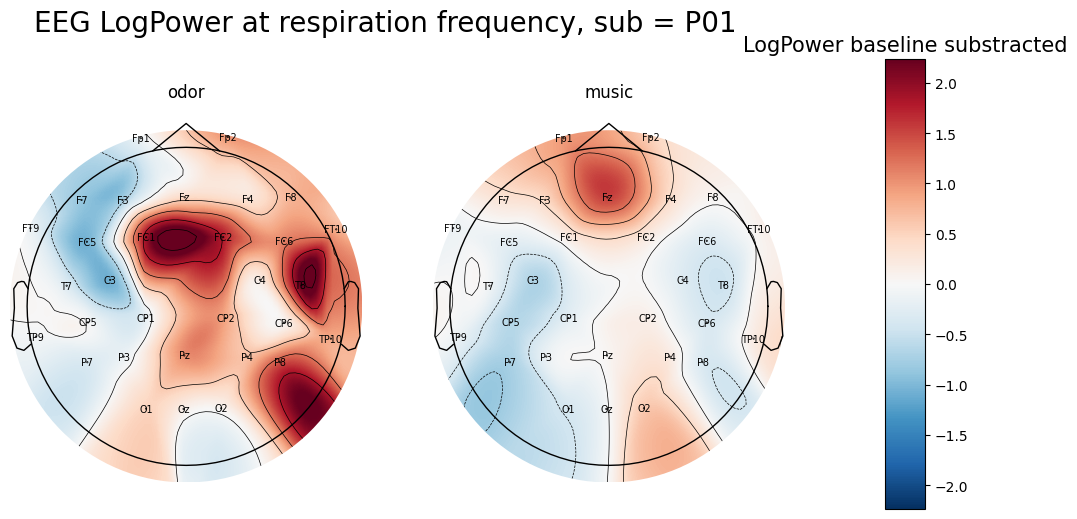

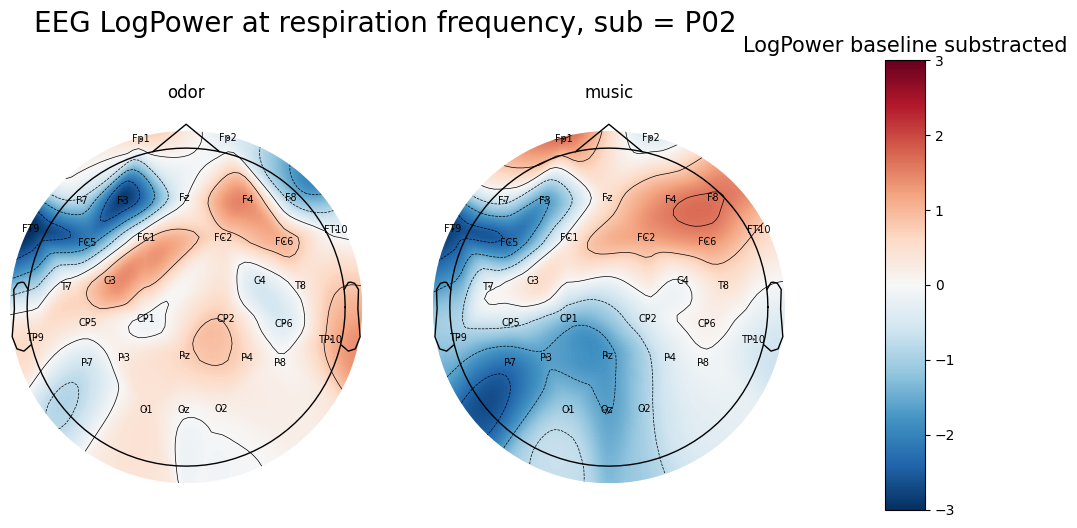

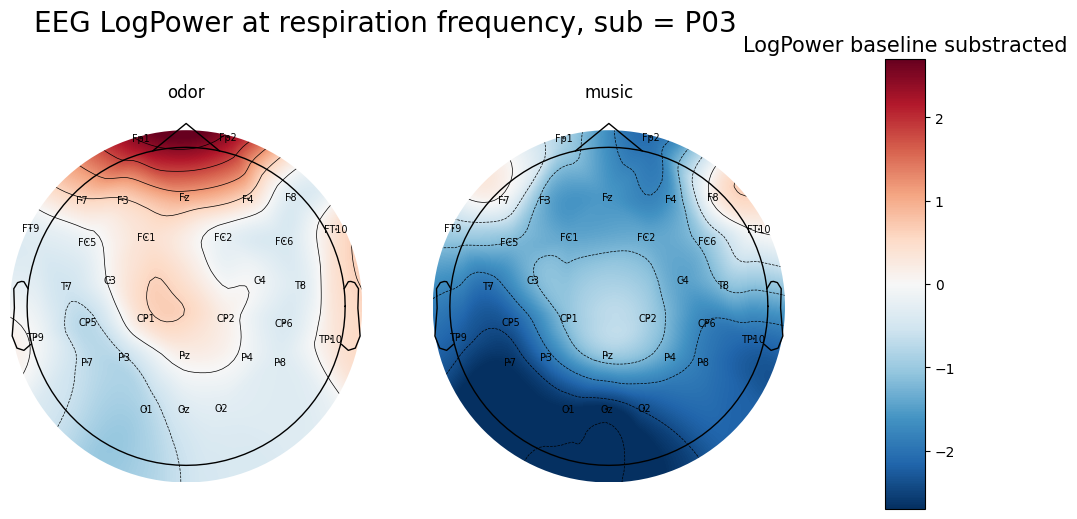

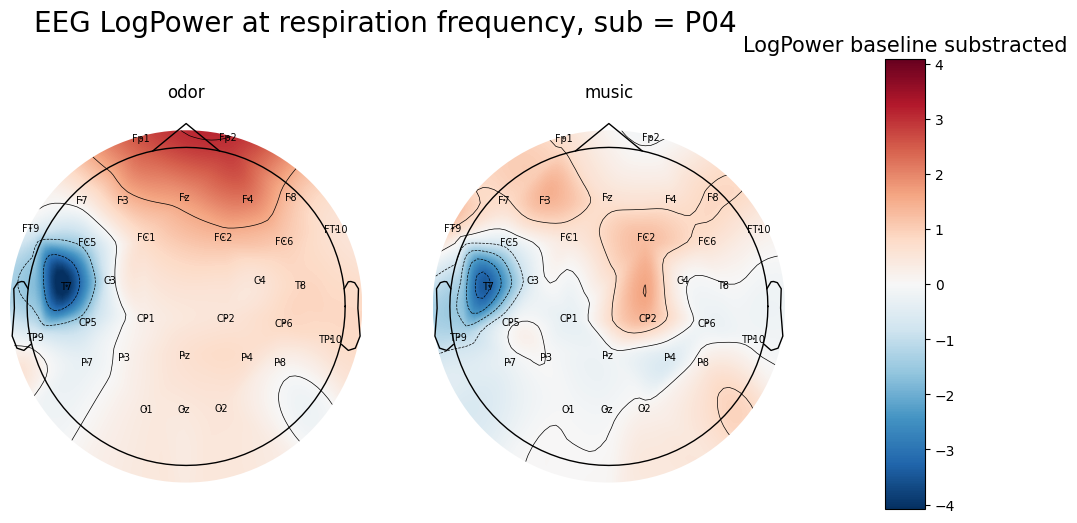

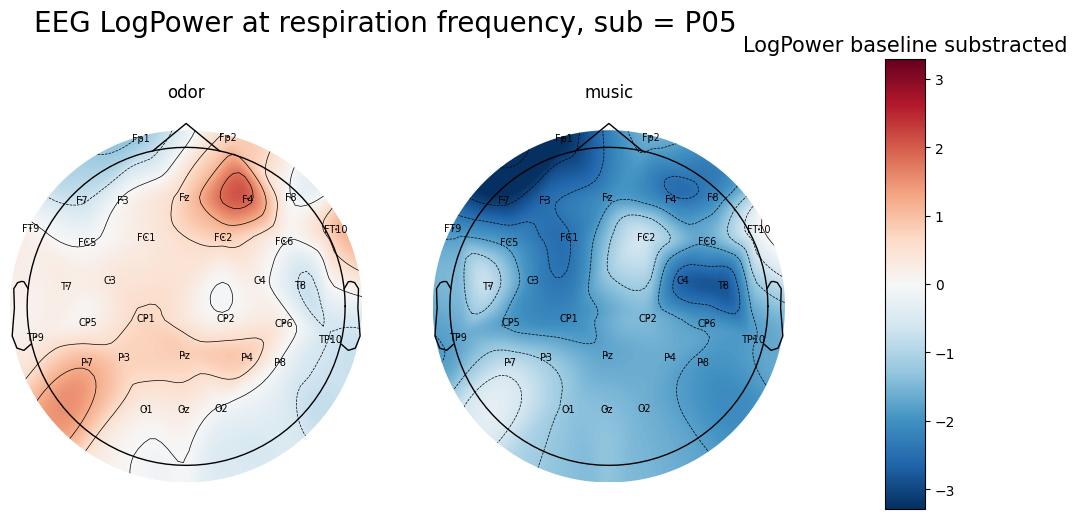

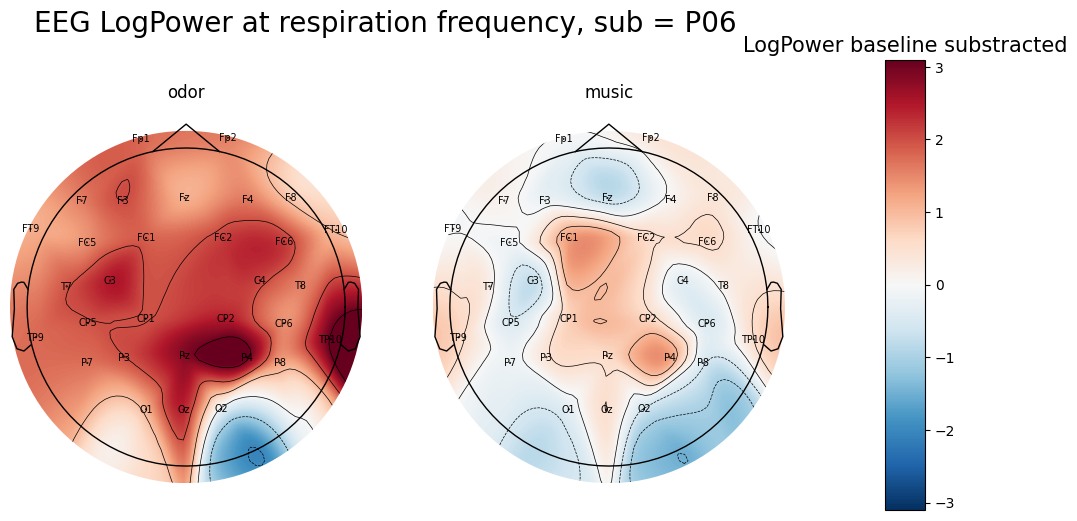

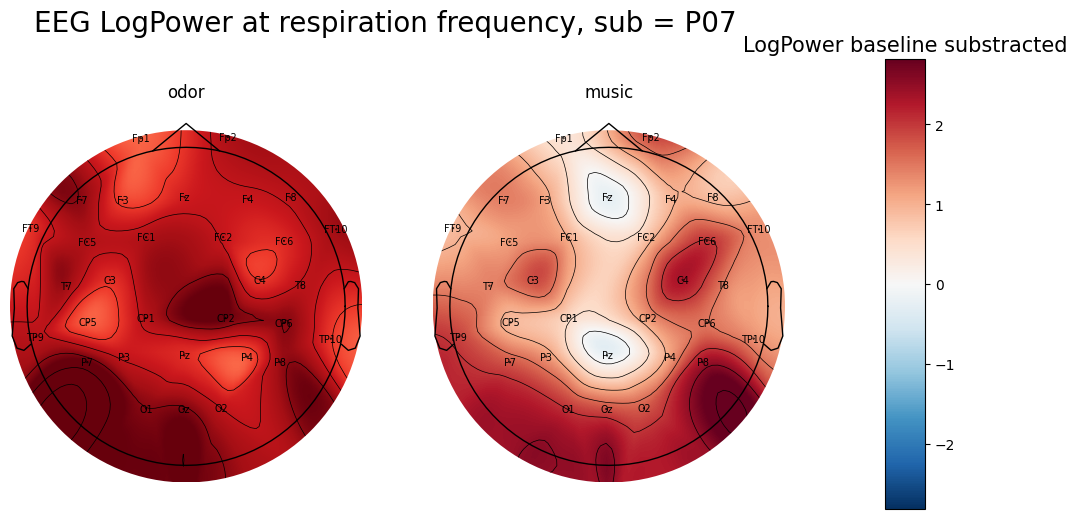

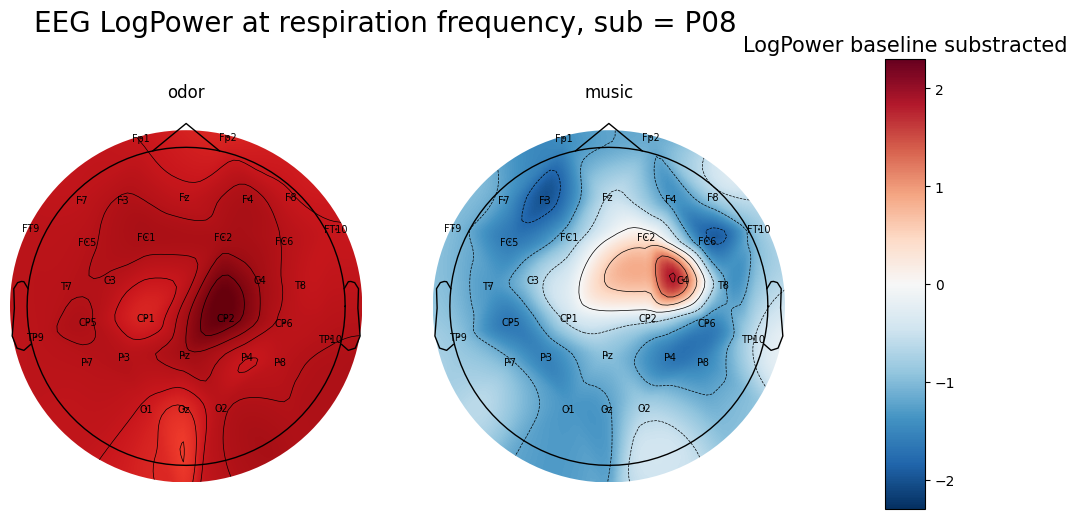

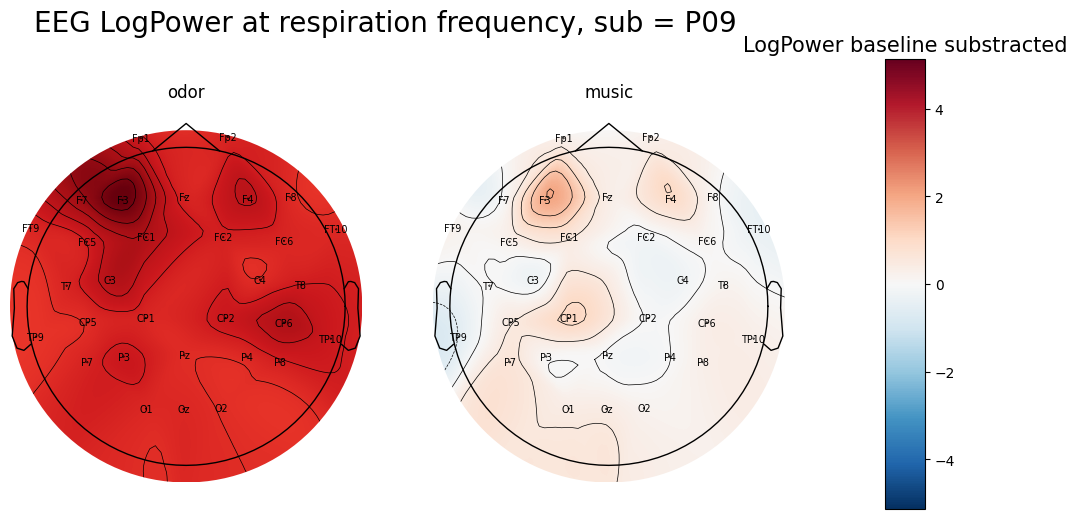

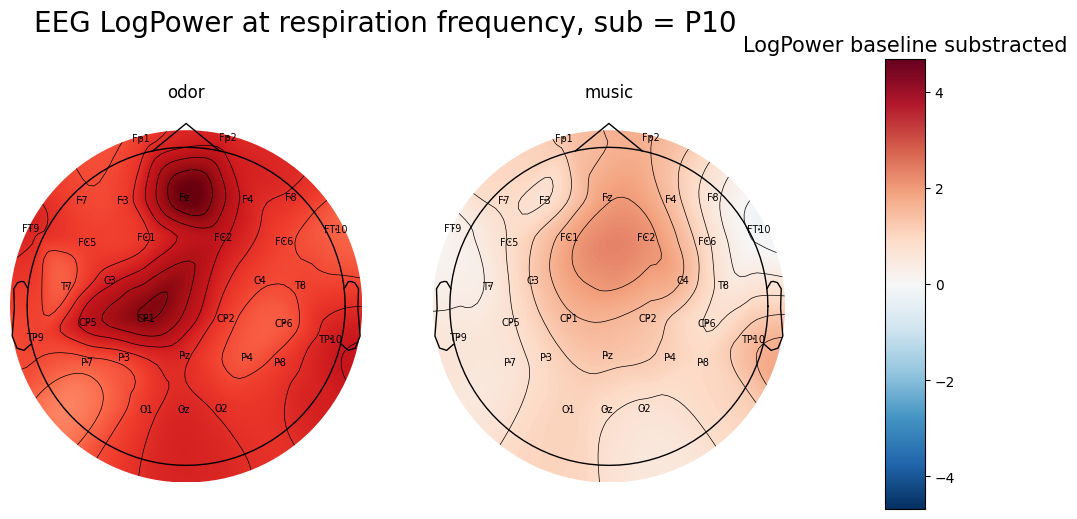

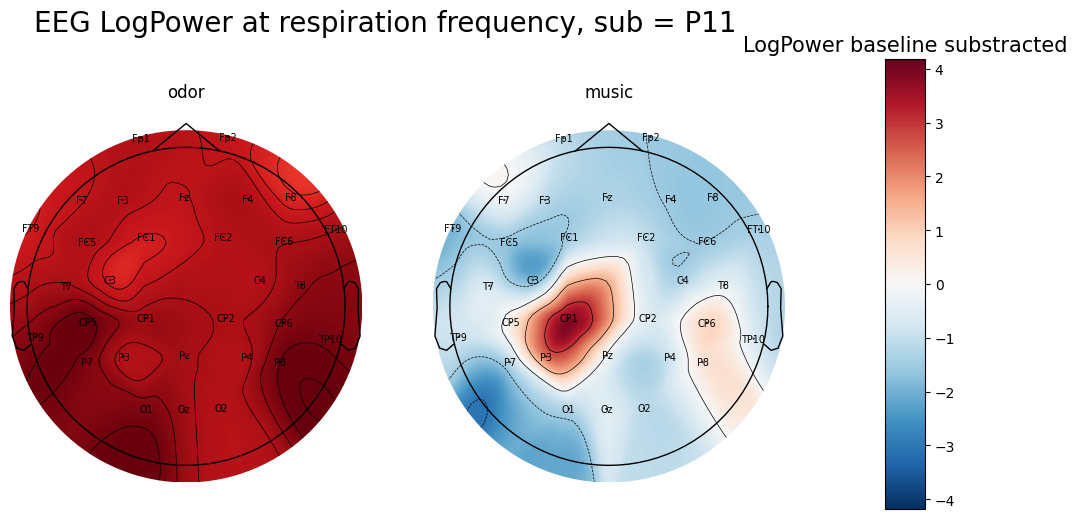

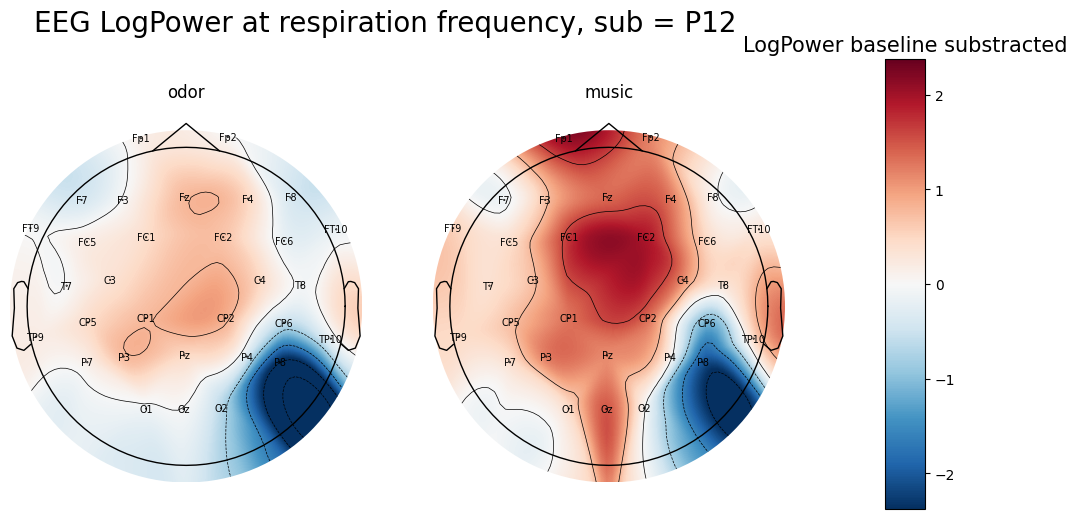

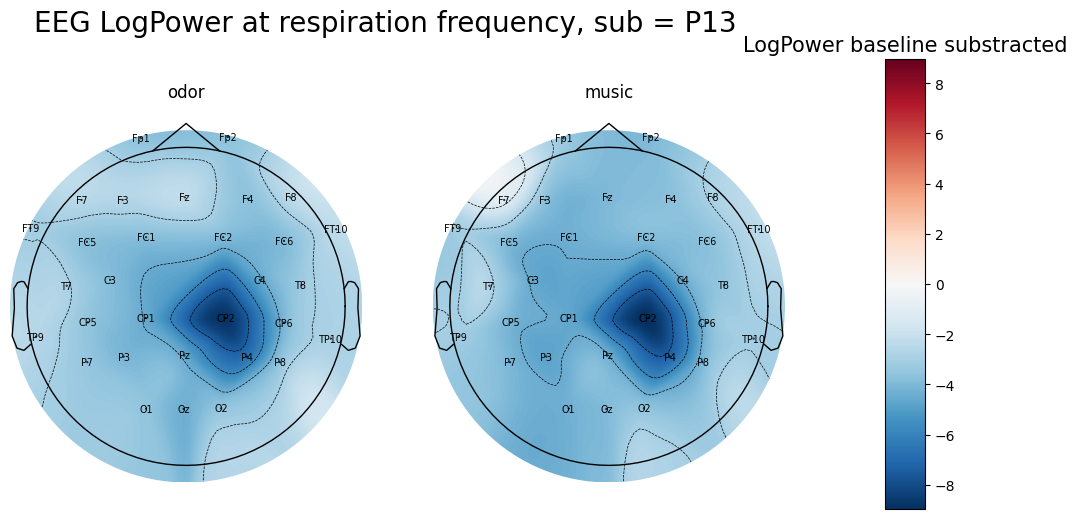

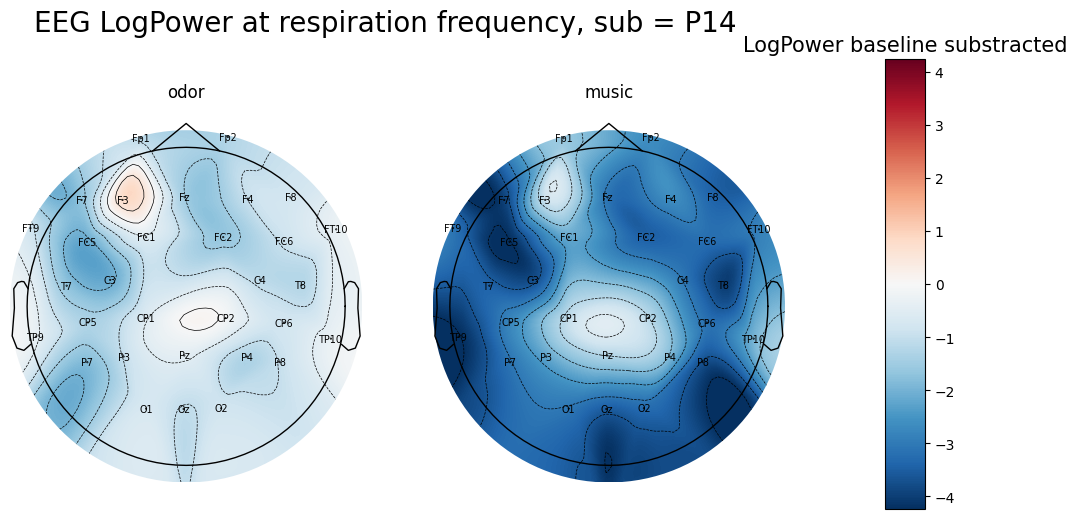

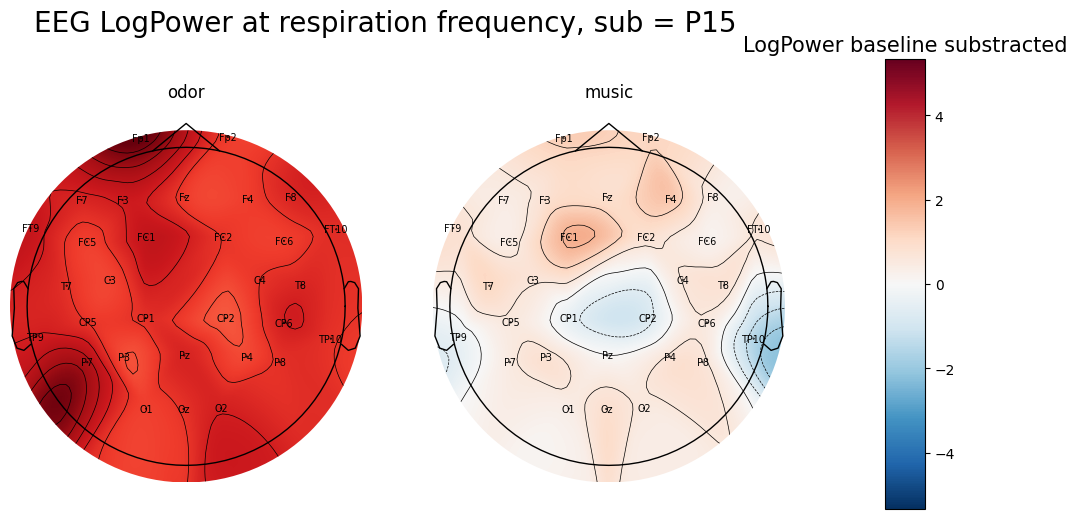

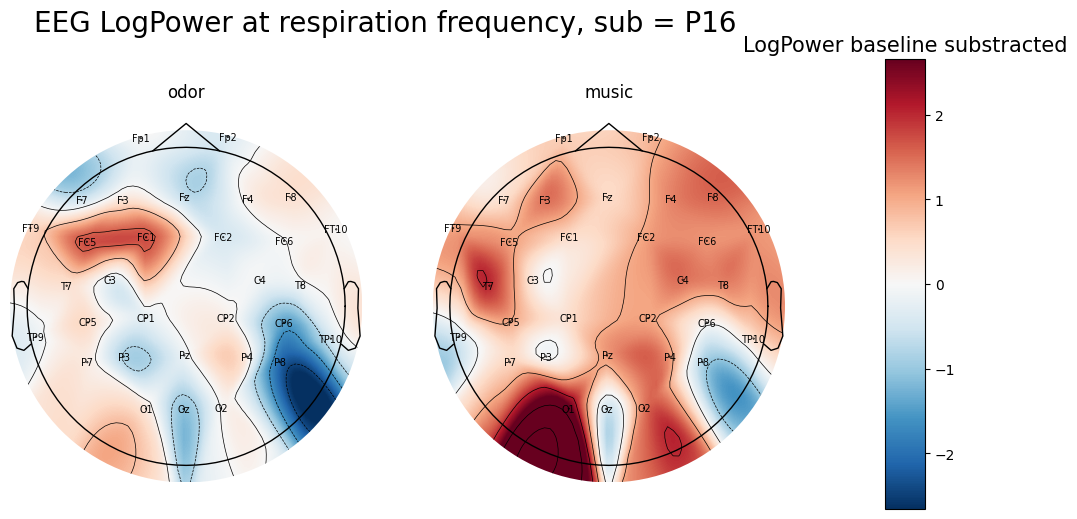

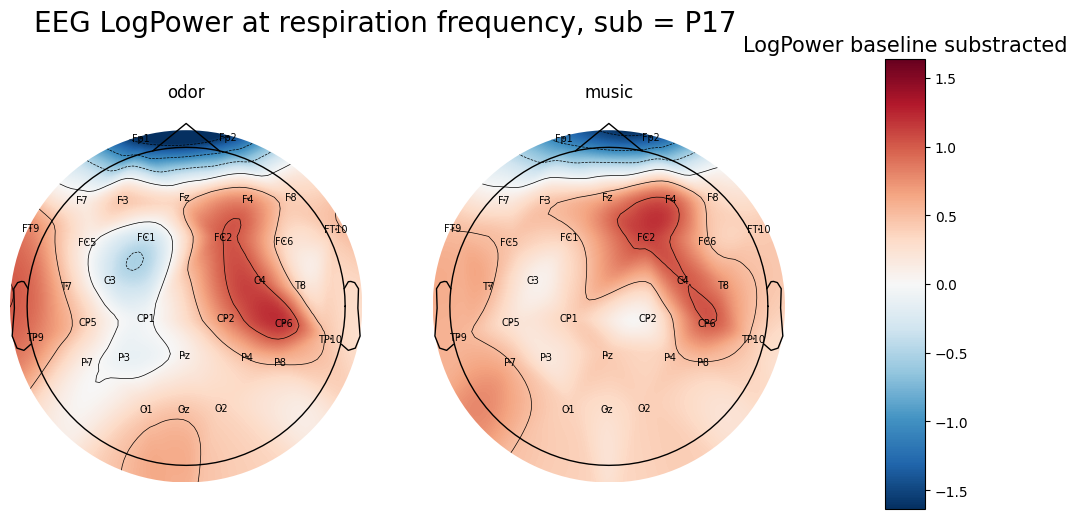

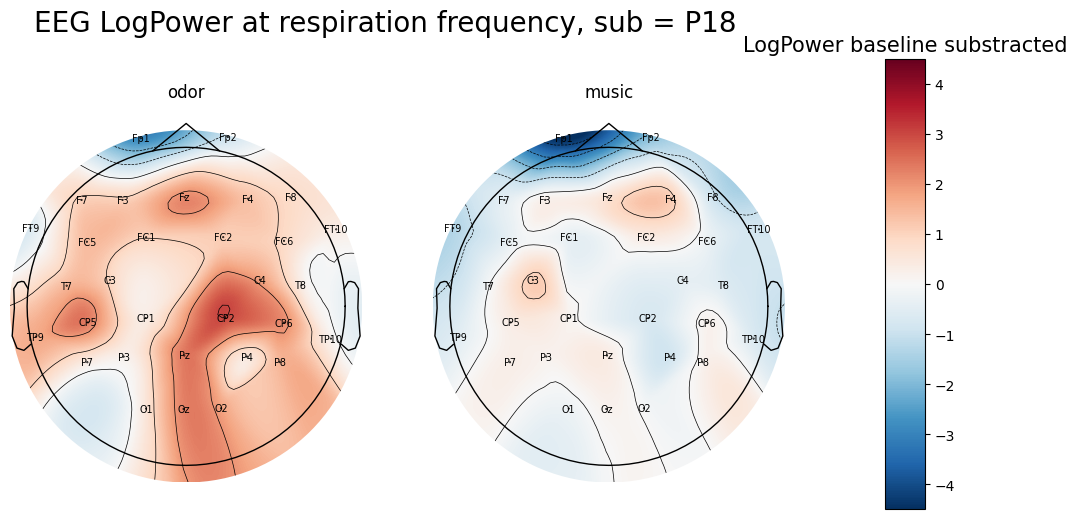

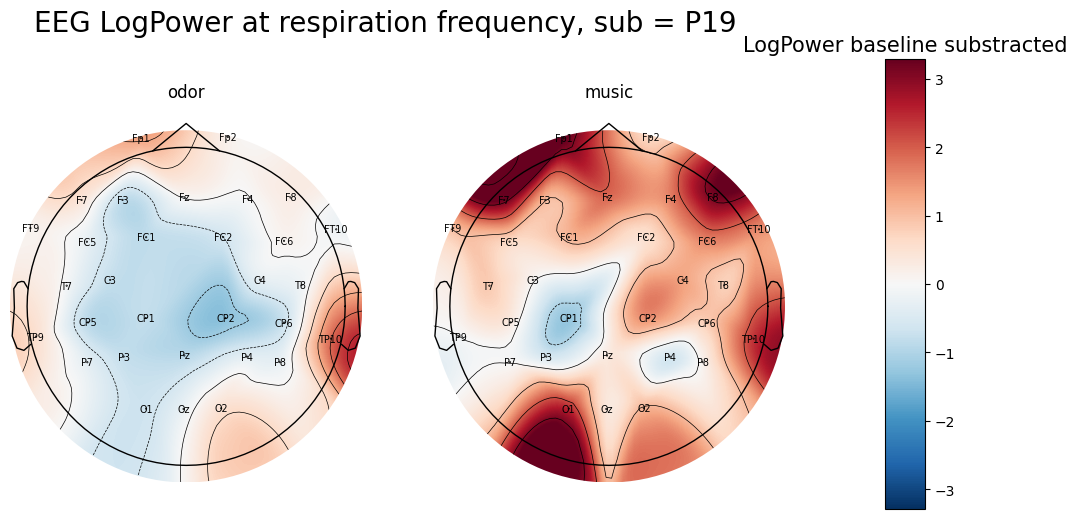

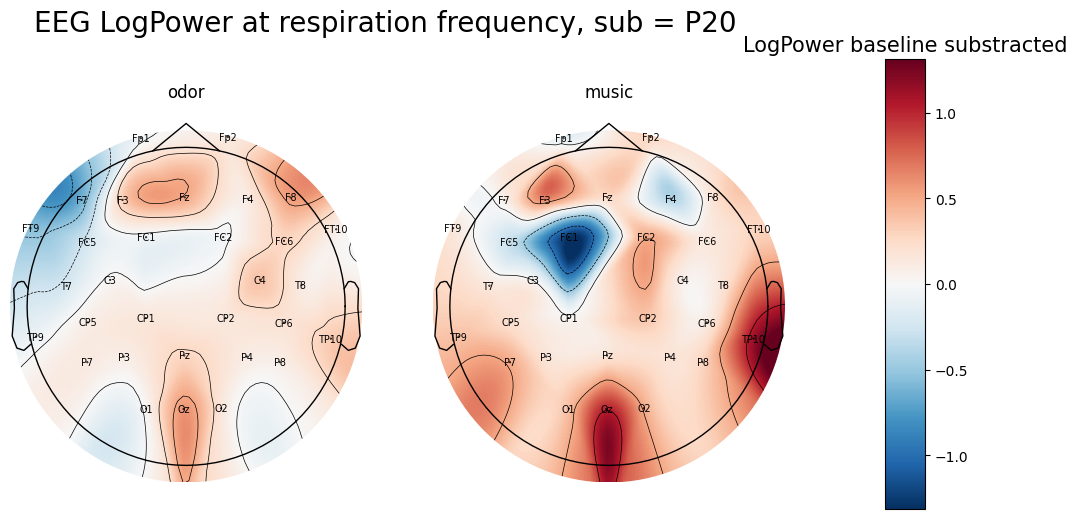

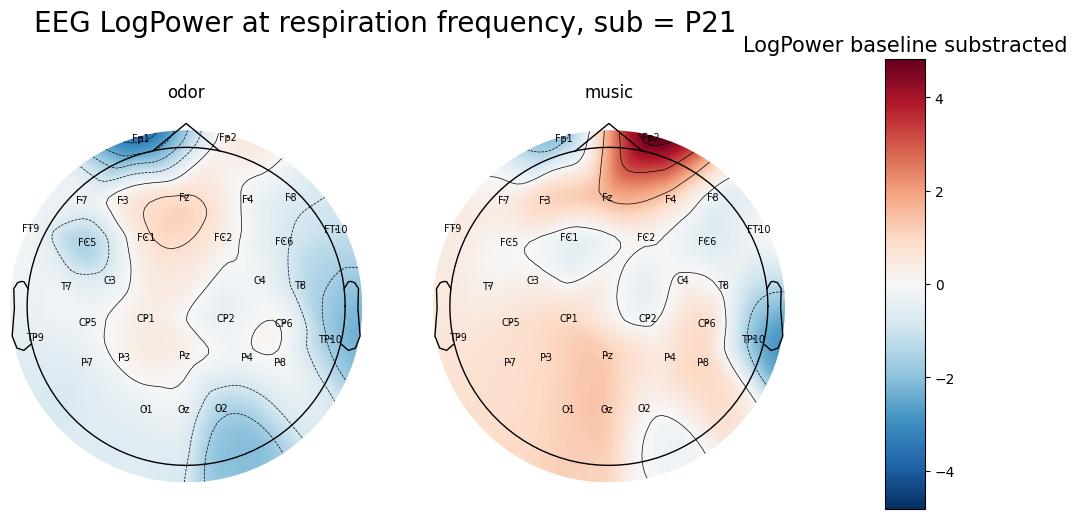

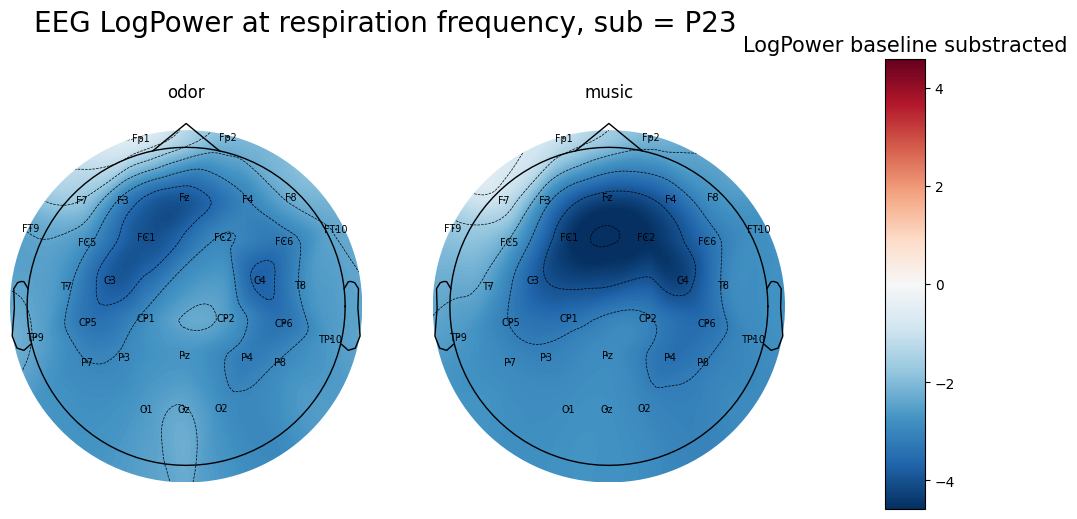

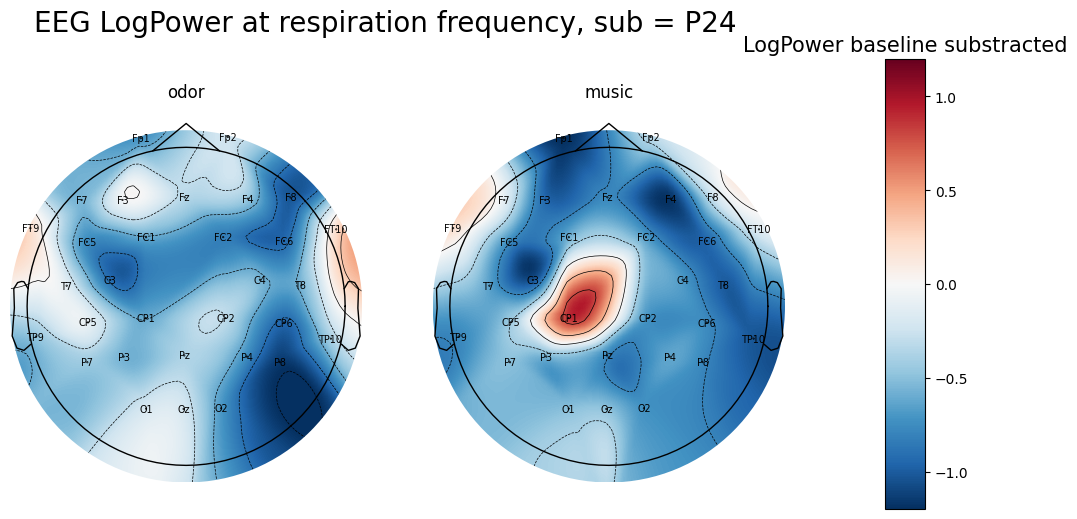

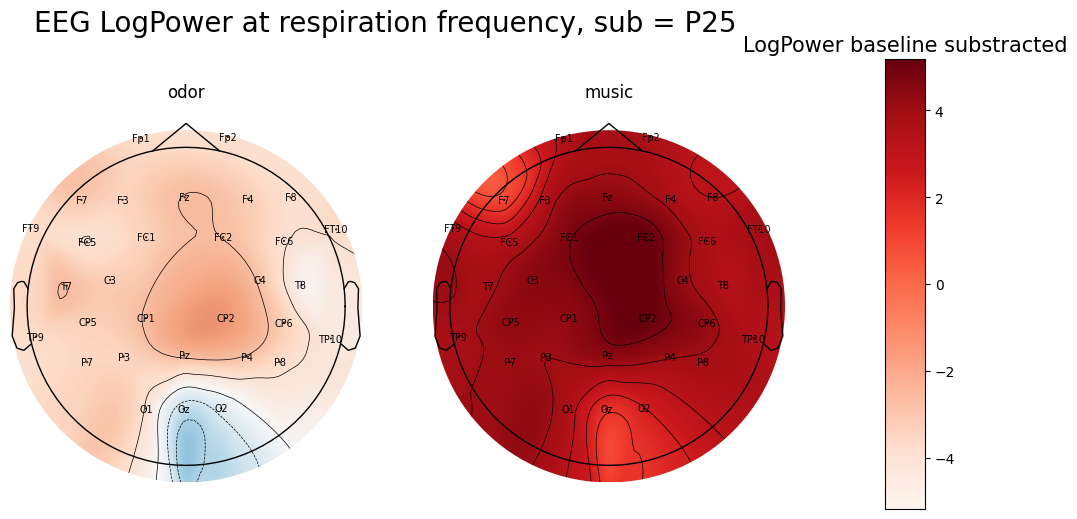

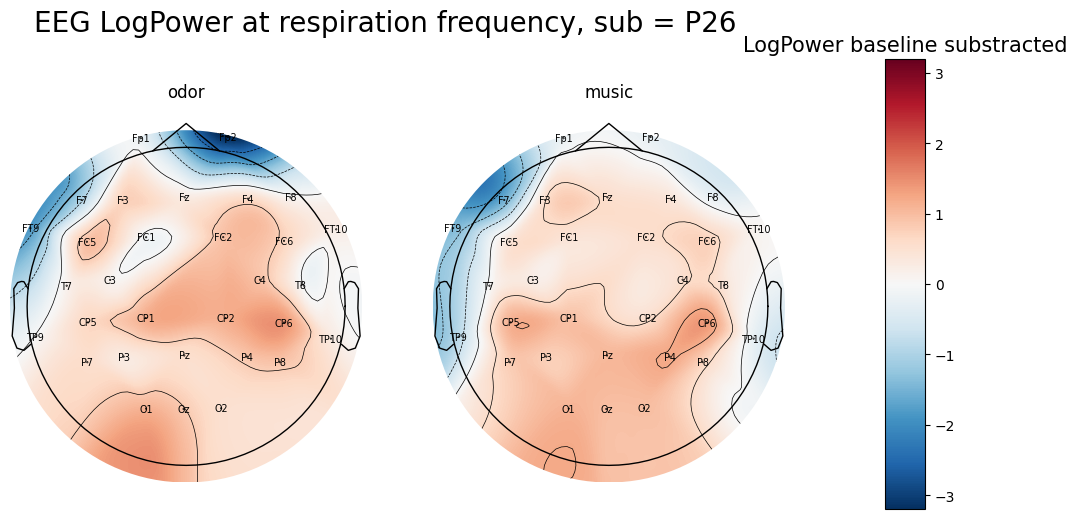

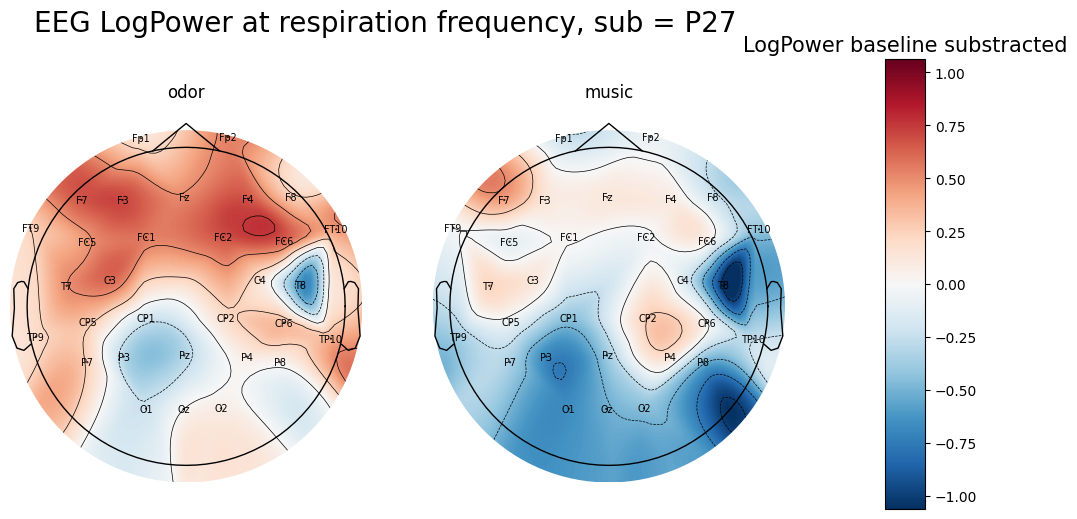

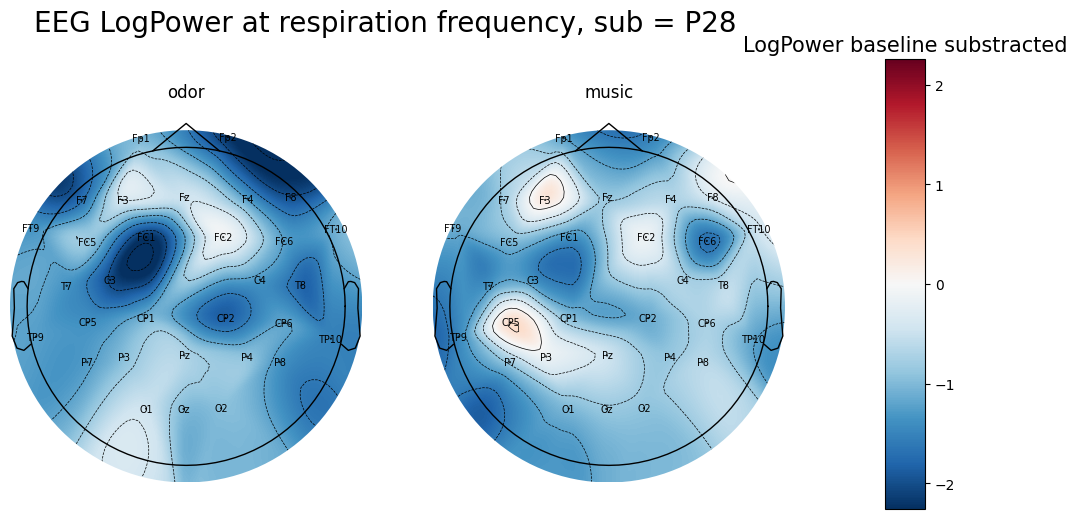

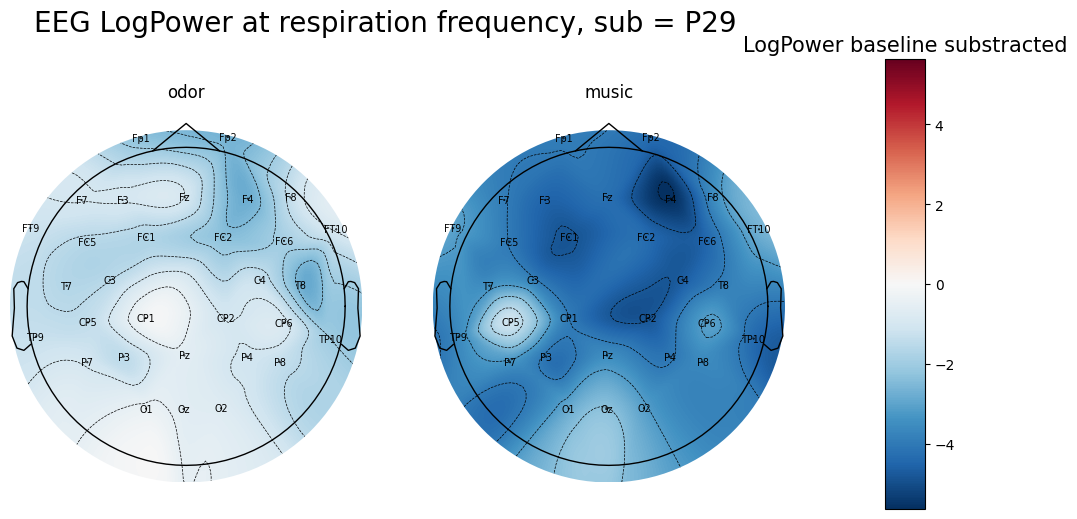

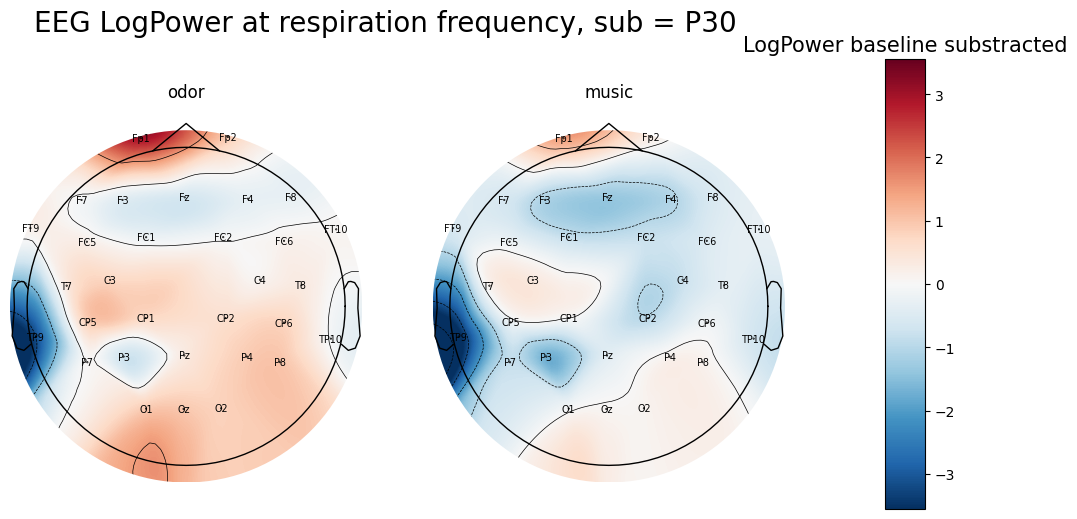

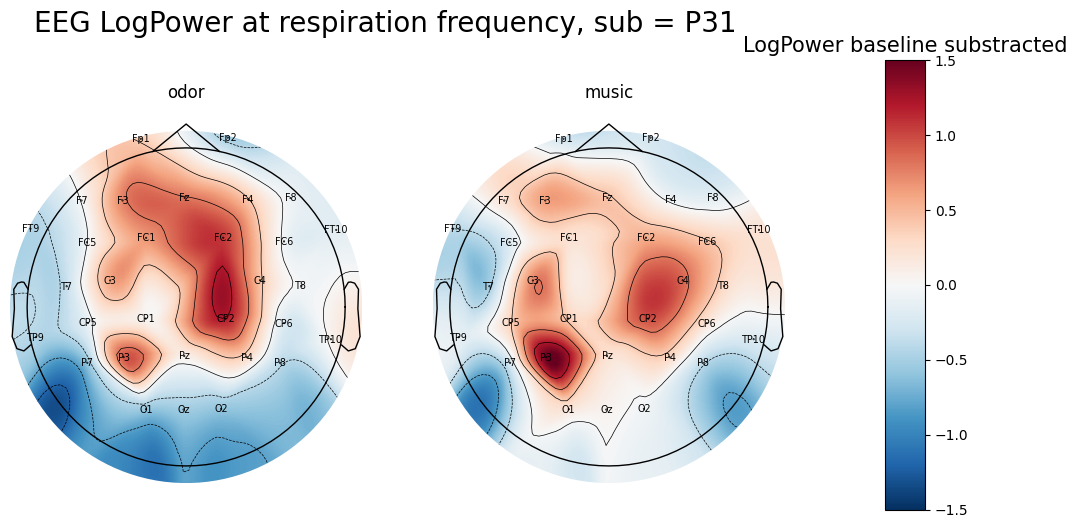

In [12]:
delta_quantile = 0.

colname = 'log_max_eeg'

for subject in subject_keys:
    
    df = power_at_resp_baselined[power_at_resp_baselined['participant'] == subject]
    
    vmin = np.quantile(df.groupby(['session','chan']).mean(numeric_only = True)[colname].values, delta_quantile)
    vmax = np.quantile(df.groupby(['session','chan']).mean(numeric_only = True)[colname].values, 1 - delta_quantile)
    
    vmin = vmin if abs(vmin) > abs(vmax) else -vmax
    vmax = vmax if abs(vmin) < abs(vmax) else abs(vmin)

    pos = get_pos()

    fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
    fig.suptitle(f'EEG LogPower at respiration frequency, sub = {subject}', fontsize = 20, y = 1.1)

    for c, session in enumerate(df['session'].unique()):
        ax = axs[c]
        topo_data = df[df['session'] == session].groupby('chan').mean(numeric_only = True)[colname].reindex(eeg_chans)
        im, cn = mne.viz.plot_topomap(data =topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax))
        ax.set_title(f'{session}')

    ax_x_start = 1
    ax_x_width = 0.04
    ax_y_start = 0.1
    ax_y_height = 0.9
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im, cax=cbar_ax)
    clb.ax.set_title('LogPower baseline substracted',fontsize=15)

    file = base_folder / 'Figures' / 'power_at_resp' / 'by_subject' / f'{subject}.png'

    fig.savefig(file, bbox_inches = 'tight')